#Students:
Ofir Nesher - 204502926

Yuval Katz - 311132468

Ofer Gross - 304997067

https://colab.research.google.com/drive/1Lnixj_SlTu1S-ihwgpmmt-VTIJDhjYgG

# Assignment 2

This assignment is about training and evaluating a POS tagger with some real data. The dataset is available through the Universal Dependencies (https://universaldependencies.org/) (UD) project. To get to know the project, please visit https://universaldependencies.org/introduction.html)

In [ ]:
import numpy as np
import operator
import nltk
import pandas as pd

!pip install conllutils
import conllutils

# Ofir added:
!pip install conll-df
from conll_df import conll_df # https://github.com/interrogator/conll-df
###

---
**Part 1** (getting the data)

You can download the dataset files directly from the UD website, but it will let you only download all the languages in one compressed file. In this assignment you will be working with th GUM dataset, which you can download directly from:
https://github.com/UniversalDependencies/UD_English-GUM.
Please download it to your colab machine.



In [ ]:
!git clone https://github.com/UniversalDependencies/UD_English-GUM
%cd /content/UD_English-GUM/
!git checkout 2c8b062269f2d2d3d62405c82d8c25cf24f705dd
%cd ..

fatal: destination path 'UD_English-GUM' already exists and is not an empty directory.
/content/UD_English-GUM
Note: checking out '2c8b062269f2d2d3d62405c82d8c25cf24f705dd'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2c8b062 Updated statistics.
/content


We will use the (train/dev/test) files:

UD_English-GUM/en_gum-ud-train.conllu

UD_English-GUM/en_gum-ud-dev.conllu

UD_English-GUM/en_gum-ud-test.conllu

They are all formatted in the conllu format. You may read about it [here](https://universaldependencies.org/format.html). There is a utility library **conllutils**, which can help you read the data into the memory. It has already been installed and imported above.

You should write a code that reads the three datasets into memory. You may choose the data structure by yourself. As you can see, every word is represented by a line, with columns representing specific features. We are only interested in the first and fourth columns, corresponding to the word and its POS tag.

In [ ]:
FOLDER = 'UD_English-GUM'
WORD = 'w'
POS = 'x'

train_file = f'{FOLDER}/en_gum-ud-train.conllu'
test_file = f'{FOLDER}/en_gum-ud-test.conllu'
dev_file = f'{FOLDER}/en_gum-ud-dev.conllu'

train_df = conll_df(train_file, file_index=False)[[WORD, POS]] # the word and the POS (Part-Of-Speech) tag
test_df = conll_df(test_file, file_index=False)[[WORD, POS]]
dev_df = conll_df(dev_file, file_index=False)[[WORD, POS]]

In [ ]:
dev_df

w      x
s   i                      
1   1   Introduction   NOUN
2   1       Research   NOUN
    2             on    ADP
    3  adult-learned    ADJ
    4         second    ADJ
...              ...    ...
784 3             or  CCONJ
    4       strainer   NOUN
    5             to   PART
    6           hold   VERB
    7         filter   NOUN

[15598 rows x 2 columns]

In [ ]:
print(train_df.head(10), '\n')
print('=========')
print(test_df.head(10), '\n')
print('=========')
print(dev_df.head(10))

                w      x
s i                     
1 1     Aesthetic    ADJ
  2  Appreciation   NOUN
  3           and  CCONJ
  4       Spanish    ADJ
  5           Art   NOUN
  6             :  PUNCT
2 1      Insights   NOUN
  2          from    ADP
  3  Eye-Tracking   NOUN
3 1        Claire  PROPN 

                   w      x
s i                        
1 1              The    DET
  2       prevalence   NOUN
  3               of    ADP
  4   discrimination   NOUN
  5           across    ADP
  6           racial    ADJ
  7           groups   NOUN
  8               in    ADP
  9     contemporary    ADJ
  10         America  PROPN 

                 w      x
s i                      
1 1   Introduction   NOUN
2 1       Research   NOUN
  2             on    ADP
  3  adult-learned    ADJ
  4         second    ADJ
  5       language   NOUN
  6              (  PUNCT
  7             L2   NOUN
  8              )  PUNCT
  9            has    AUX


**This is an example of how a sentence in the test file looks**:

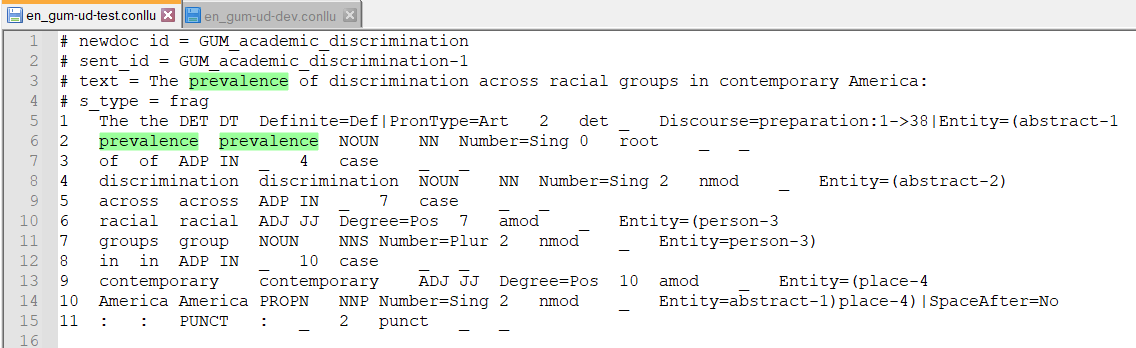

---
**Part 2**

Write a class **simple_tagger**, with methods *train* and *evaluate*. The method *train* receives the data as a list of sentences, and use it for training the tagger. In this case, it should learn a simple dictionary that maps words to tags, defined as the most frequent tag for every word (in case there is more than one most frequent tag, you may select one of them randomly). The dictionary should be stored as a class member for evaluation.

The method *evaluate* receives the data as a list of sentences, and use it to evaluate the tagger performance. Specifically, you should calculate the word and sentence level accuracy.
The evaluation process is simply going word by word, querying the dictionary (created by the train method) for each word’s tag and compare it to the true tag of that word. The word-level accuracy is the number of successes divided by the number of words. For OOV (out of vocabulary, or unknown) words, the tagger should assign the most frequent tag in the entire training set (i.e., the mode). The function should return the two numbers: word level accuracy and sentence level accuracy.

In [ ]:
# helper functions

def get_list_of_sentences(df):
    number_of_sentences = df[WORD].keys()[-1][0] # get the last sentence (s column) value === number of sentences in df
    sentences = [df.loc[(i)][WORD].str.cat(sep=' ') for i in range(1, number_of_sentences + 1)]
    return sentences


def get_all_unique_words(df):
    return df[WORD].values.unique()


def get_most_frequent_tag_per_word(df):
    words_dict = dict(zip(df.w, df.x)) # this sets each word's value as as the most RECENT POS tag seen in data!

    # therefore, we should override each word's value by its MOST FREQUENT POS tag:
    for word, tag in words_dict.items():
        words_dict[word] = (df[df[WORD] == word][POS].values.mode()[0])

    return words_dict


def get_most_frequent_tag_in_data(df):
    # the "mode" of a list is the most likely value to appear (most frequent)
    return df[POS].values.mode()[0]

In [ ]:
class simple_tagger:
    def __init__(self):
        self.dictionary = {} # "The dictionary should be stored as a class member for evaluation"
        self.most_frequent_tag = None # For OOV (out of vocabulary, or unknown) words, the tagger should assign the most frequent tag in the entire training set (i.e., the mode)


    def train(self, data):
        self.dictionary = get_most_frequent_tag_per_word(data)
        self.most_frequent_tag = get_most_frequent_tag_in_data(data)


    def evaluate(self, data):
        total_words_hits = 0
        sentence_hits = 0 # number of sentences in which all words are correctly classified
        number_of_words_with_duplicates = len(data[WORD])
        sentences = get_list_of_sentences(data)
        
        for i, sentence in enumerate(sentences, 1): # index starts at 1 because that's how the dataframe works
            # check every word and sentence's accuracy
            sentence_in_df = data.loc[(i)]
            words = sentence.split()
            words_hits = 0

            for word in words:
                actual_tag = sentence_in_df[sentence_in_df[WORD] == word][POS].values[0]
                
                if word in self.dictionary:
                    predicted_tag = self.dictionary[word]
                else:
                    predicted_tag = self.most_frequent_tag
                
                if actual_tag == predicted_tag:
                    words_hits += 1

            total_words_hits += words_hits

            if words_hits == len(words):
                sentence_hits += 1

        word_level_accuracy = round(total_words_hits / number_of_words_with_duplicates * 100, 4)
        sentence_level_accuracy = round(sentence_hits / len(sentences) * 100, 4)
        
        return word_level_accuracy, sentence_level_accuracy

In [ ]:
tagger = simple_tagger()
tagger.train(train_df)

# https://piazza.com/class/klxc3m1tzqz2o8?cid=40 - "You should evaluate on the test and dev datasets separately. The train file is for training only"
simple_tagger_word_level_accuracy_train, simple_tagger_sentence_level_accuracy_train = tagger.evaluate(train_df)
simple_tagger_word_level_accuracy_test, simple_tagger_sentence_level_accuracy_test = tagger.evaluate(test_df)
simple_tagger_word_level_accuracy_dev, simple_tagger_sentence_level_accuracy_dev = tagger.evaluate(dev_df)

In [ ]:
print(f'*train* data: word accuracy = {simple_tagger_word_level_accuracy_train} %, sentence accuracy = {simple_tagger_sentence_level_accuracy_train} %')
print(f'*test* data: word accuracy = {simple_tagger_word_level_accuracy_test} %, sentence accuracy = {simple_tagger_sentence_level_accuracy_test} %')
print(f'*dev* data: word accuracy = {simple_tagger_word_level_accuracy_dev} %, sentence accuracy = {simple_tagger_sentence_level_accuracy_dev} %')

*train* data: word accuracy = 93.98 %, sentence accuracy = 41.4509 %
*test* data: word accuracy = 84.6038 %, sentence accuracy = 19.1011 %
*dev* data: word accuracy = 85.652 %, sentence accuracy = 15.8163 %


---
**Part 3**

Similar to part 2, write the class hmm_tagger, which implements HMM tagging. The method *train* should build the matrices A, B and Pi, from the data as discussed in class. The method *evaluate* should find the best tag sequence for every input sentence using he Viterbi decoding algorithm, and then calculate the word and sentence level accuracy using the gold-standard tags. You should implement the Viterbi algorithm in the next block and call it from your class.

Additional guidance:
1. The matrix B represents the emissions probabilities. Since B is a matrix, you should build a dictionary that maps every unique word in the corpus to a serial numeric id (starting with 0). This way columns in B represents word ids.
2. During the evaluation, you should first convert each word into it’s index and then create the observation array to be given to Viterbi, as a list of ids. OOV words should be assigned with a random tag. To make sure Viterbi works appropriately, you can simply break the sentence into multiple segments every time you see an OOV word, and decode every segment individually using Viterbi.

In [ ]:
def update_A(A, i, currentSentenceTags):
    currentTag = currentSentenceTags[i]
    previousTag = currentSentenceTags[i-1]
    A.loc[previousTag, currentTag] +=1


def update_B(B, currentSentenceWords, currentSentenceTags):
    for word, tag in zip(currentSentenceWords, currentSentenceTags):
        B.loc[tag, word]+=1


def updatePi(Pi, currentTag):
    Pi[currentTag] +=1

In [ ]:
def calc_A_B_Pi(data):
  number_of_sentences = data[WORD].keys()[-1][0]
  uniqueTags = set(data[POS])
  uniqueWords = set(data[WORD])

  # numOfTagsOccuresDict = dict.fromkeys(list(uniqueTags),0)
  A = pd.DataFrame(index=uniqueTags, columns=uniqueTags).fillna(0)
  B = pd.DataFrame(index=uniqueTags, columns=uniqueWords).fillna(0)

  # dict for every tag and its initial probability
  Pi = dict.fromkeys(list(uniqueTags),0)

  for j in range(1, number_of_sentences+1):
    currentSentenceTags = data.loc[(j)][POS]
    currentSentenceWords = data.loc[(j)][WORD]
    
    update_B(B, currentSentenceWords, currentSentenceTags)

    for i in range(1, len(currentSentenceTags)+1):

      if i == 1:
        currentTag = currentSentenceTags[i]
        updatePi(Pi, currentTag)
      else:
        update_A(A, i, currentSentenceTags)

  A["sum"] = A.sum(axis=1)
  A = A.loc[:, A.columns != 'sum'].div(A["sum"], axis=0)

  B["sum"] = B.sum(axis=1)
  B = B.loc[:, B.columns != 'sum'].div(B["sum"], axis=0)
  
  for tag in Pi.keys():
     Pi[tag] /= number_of_sentences

  return A, B, Pi

In [ ]:
def wordsToIdx(words, B_columns):
    columns_as_list = list(B_columns)
    wordsAsIdxSegment = []
    
    for word in words:
        wordsAsIdxSegment.append(columns_as_list.index(word))

    return wordsAsIdxSegment

In [ ]:
def segmentOfWordsToSentencePrediction(self, segment, sentencePredict, last=False):
    if segment:
        segmentIdx = wordsToIdx(segment, self.B.columns)
        segmentPredict = viterbi(segmentIdx, self.A, self.B, self.Pi)
        sentencePredict += segmentPredict

    if not last:
        random_tag = np.random.choice(self.A.index)
        sentencePredict.append(random_tag)

In [ ]:
class hmm_tagger:
  def __init__(self):
    self.uniqueWordsArr = []
    self.A = []
    self.B = []
    self.Pi = {}


  def train(self, data):
    self.A, self.B, self.Pi = calc_A_B_Pi(data)
    self.uniqueWordsArr = list(self.B.columns)


  def evaluate(self, data):
        total_words_hits = 0
        sentence_hits = 0 # number of sentences in which all words are correctly classified
        number_of_words_with_duplicates = len(data[WORD])
        sentences = get_list_of_sentences(data)
        
        for i, sentence in enumerate(sentences, 1): # index starts at 1 because that's how the dataframe works
            # check every word and sentence's accuracy
            sentence_in_df = data.loc[(i)]
            words = sentence.split()
            words_hits = 0
            sentenceIdx = []

            for word in words:
              if word in self.uniqueWordsArr:
                wordIdx = list(self.B).index(word)
                sentenceIdx.append(wordIdx)
              else:
                randomTagIdx = np.random.randint(len(self.uniqueWordsArr))
                sentenceIdx.append(randomTagIdx)
        
            sentencePredict = viterbi(sentenceIdx, self.A, self.B, self.Pi)

            for j, word in enumerate(words, 0):
                actual_tag = sentence_in_df[sentence_in_df[WORD] == word][POS].values[0]
                
                predicted_tag = sentencePredict[j]
                
                if actual_tag == predicted_tag:
                    words_hits += 1

            total_words_hits += words_hits

            if words_hits == len(words):
                sentence_hits += 1

        word_level_accuracy = round(total_words_hits / number_of_words_with_duplicates *100, 4)
        sentence_level_accuracy = round(sentence_hits / len(sentences) *100, 4)
        
        return word_level_accuracy, sentence_level_accuracy

In [ ]:
def findBestTag(delta_df, t):
    maxValue = 0
    bestTag = ''

    for tag in delta_df.index:
        currentValue =delta_df.loc[tag, t]
        
        if currentValue > maxValue:
            maxValue = currentValue
            bestTag = tag
    
    return bestTag

In [ ]:
# Viterbi
def viterbi (observations, A, B, Pi):
  #...
# creates variables
  delta_df = pd.DataFrame(index=B.index, columns=np.arange(len(observations))).fillna(0) 
  psi_df = pd.DataFrame(index=B.index, columns=np.arange(len(observations))).fillna(0)
  best_sequence = [0]*len(observations)
  
  firstObserv = observations[0]
  listOfWords = list(B.columns)
  firstObservWord = listOfWords[firstObserv]

# initializtion step
  for tag in delta_df.index:
    b = B.loc[tag, firstObservWord]
    delta_df.loc[tag, 0] = b*Pi[tag]
    psi_df.loc[tag, 0] = 0

# iteration step
  for observIdx, currentObserv in enumerate(observations[1:], 1):
    currentObservWord = listOfWords[currentObserv]
    valuesToTakeMax = []

    maxValue = 0
    bestTagForMaxValue = ''

    for tag in delta_df.index:
      b = B.loc[tag, currentObservWord]

      for tag2 in delta_df.index:
        currentValue = delta_df.loc[tag2, observIdx-1] * A.loc[tag2, tag]

        if currentValue > maxValue:
          maxValue = currentValue
          bestTagForMaxValue = tag2
          
      delta_df.loc[tag, observIdx] = maxValue*b
      psi_df.loc[tag, observIdx] = bestTagForMaxValue


# sequence recovery
  t = len(observations)-1
  best_sequence[t] = findBestTag(delta_df, t)

  for t in range(len(observations)-2, -1, -1):
    best_sequence[t] = psi_df.loc[best_sequence[t+1], t+1]

  return best_sequence

# A simple example to run the Viterbi algorithm:
#( Same as in presentation "NLP 3 - Tagging" on slide 35)

# A = np.array([[0.3, 0.7], [0.2, 0.8]])
# B = np.array([[0.1, 0.1, 0.3, 0.5], [0.3, 0.3, 0.2, 0.2]])
# Pi = np.array([0.4, 0.6])
# print(viterbi([0, 3, 1, 0], A, B, Pi))
# Expected output: 1, 1, 1, 1

In [ ]:
hmmTagger = hmm_tagger()

In [ ]:
hmmTagger.train(train_df)

In [ ]:
hmm_word_level_accuracy_test, hmm_sentence_level_accuracy_test = hmmTagger.evaluate(test_df)
hmm_word_level_accuracy_dev, hmm_sentence_level_accuracy_dev = hmmTagger.evaluate(dev_df)

In [ ]:
print(f'*test* data: word accuracy = {hmm_word_level_accuracy_test} %, sentence accuracy = {hmm_sentence_level_accuracy_test} %')
print(f'*dev* data: word accuracy = {hmm_word_level_accuracy_dev} %, sentence accuracy = {hmm_sentence_level_accuracy_dev} %')

*test* data: word accuracy = 81.5522 %, sentence accuracy = 12.809 %
*dev* data: word accuracy = 83.4658 %, sentence accuracy = 11.2245 %


---
**Part 4**

Compare the results obtained from both taggers and a MEMM tagger, implemented by NLTK (a known NLP library), over both, the dev and test datasets. To train the NLTK MEMM tagger you should execute the following lines (it may take some time to train...):

In [ ]:
!pip install pyconll
import pyconll

In [ ]:
def parse_data(data):
    '''
    Convert the data to the correct form i.e tuples of (word, upos) in a list per word in sentence, per sentence in data
    '''
    parsed_data = []

    for sentence in data:
        parsed_sentence = [(token.form, token.upos) for token in sentence]
        parsed_data += [parsed_sentence]

    return parsed_data

In [ ]:
train = pyconll.load_from_file(train_file)
test = pyconll.load_from_file(test_file)
dev = pyconll.load_from_file(dev_file)

train_data = parse_data(train)
test_data = parse_data(test)
dev_data = parse_data(dev)

In [ ]:
from nltk.tag import tnt 

tnt_pos_tagger = tnt.TnT()
tnt_pos_tagger.train(train_data)

memm_word_level_accuracy_test = round(tnt_pos_tagger.evaluate(test_data) * 100, 4)
memm_word_level_accuracy_dev = round(tnt_pos_tagger.evaluate(dev_data) * 100, 4)

Print both, word level and sentence level accuracy for all the three taggers in a table.

In [ ]:
def evaluate_memm(tagger, data):
    sentence_hits = 0 # number of sentences in which all words are correctly classified

    for sentence_items in data:
        word_hits = 0
        sentence = [item[0] for item in sentence_items]
        state_seq = tagger.tag(sentence)

        for predicted_tag, actual_tag in zip(state_seq, sentence_items):
            word_hits += 1 if predicted_tag[1] == actual_tag[1] else 0

        if word_hits == len(sentence):
            sentence_hits += 1

    sentence_level_accuracy = round(sentence_hits / len(data) * 100, 4)

    return sentence_level_accuracy

In [ ]:
memm_sentence_level_accuracy_test = evaluate_memm(tnt_pos_tagger, test_data)
memm_sentence_level_accuracy_dev = evaluate_memm(tnt_pos_tagger, dev_data)

In [ ]:
print(f'*test* data: word accuracy = {memm_word_level_accuracy_test} %, sentence accuracy = {memm_sentence_level_accuracy_test} %')
print(f'*dev* data: word accuracy = {memm_word_level_accuracy_dev} %, sentence accuracy = {memm_sentence_level_accuracy_dev} %')

*test* data: word accuracy = 80.2336 %, sentence accuracy = 12.3596 %
*dev* data: word accuracy = 82.7863 %, sentence accuracy = 12.7551 %


In [ ]:
pd.DataFrame([
                [simple_tagger_word_level_accuracy_test, simple_tagger_sentence_level_accuracy_test, simple_tagger_word_level_accuracy_dev, simple_tagger_sentence_level_accuracy_dev],
                [hmm_word_level_accuracy_test, hmm_sentence_level_accuracy_test, hmm_word_level_accuracy_dev, hmm_sentence_level_accuracy_dev], 
                [memm_word_level_accuracy_test, memm_sentence_level_accuracy_test, memm_word_level_accuracy_dev, memm_sentence_level_accuracy_dev]
], columns=['word accuracy (test)', 'sentence accuracy (test)', 'word accuracy (dev)', 'sentence accuracy (dev)'], index=['Simple', 'HMM', 'MEMM'])

,word accuracy (test),sentence accuracy (test),word accuracy (dev),sentence accuracy (dev)
Simple,84.6038,19.1011,85.6520,15.8163
HMM,81.5522,12.8090,83.4658,11.2245
MEMM,80.2336,12.3596,82.7863,12.7551
